In [1]:
#Importing audio file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#Import plotting
import matplotlib.pyplot as plt
import seaborn as sb

#For managing sound
import librosa
import soundfile as sf

# Misc.
import warnings

warnings.filterwarnings("ignore")

### Recursively get files

In [2]:
def file_fetch(src,audio_paths,file=None):
    l=os.listdir(src)
    if(len(l)!=0):
        for i in range(len(l)):
            if(file!=None):
                if(file in l[i]):
                    audio_paths.append(str(src+l[i]))
            elif("." not in l[i]):
                try:
                    audio_fetch(str(src+"/"+l[i]+"/"),audio_paths)
                except:
                    continue
            else:
                if(".wav" in l[i] or ".mp3" in l[i] or ".aac" in l[i]):
                    audio_paths.append(str(src+l[i]))
                            

In [3]:
audio_files=[]
text_files=[]
file_fetch("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/",audio_files)
file_fetch("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/audio_and_txt_files/",text_files,".txt")
audio_files.sort()
text_files.sort()

df=pd.DataFrame(columns=["Audio","Text"])

diagnosis=pd.read_csv("../Sound_Classification/archive/respiratory_sound_database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None)

df["Audio"]=audio_files
df["Text"]=text_files

target=[]
for i in range(len(df)):
    target.append(diagnosis[diagnosis[0]==int(df.iloc[i][0].split("/")[-1].split("_")[0])][1].values[0])
ds=df.values

#train_x,test_x,train_y,test_y=train_test_split(ds,target,test_size=0.25)


timings=[]
for i in ds:
    wv,sr=librosa.load(i[0])
    time=len(wv)/sr
    timings.append(time)

<Axes: >

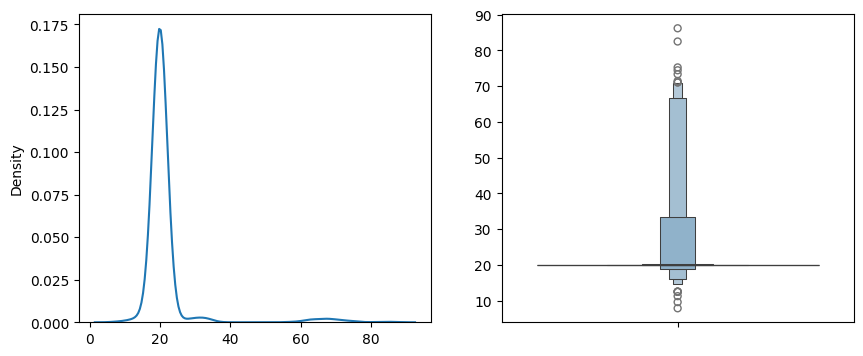

In [4]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sb.kdeplot(timings)
plt.subplot(1,2,2)
sb.boxenplot(timings)

In [5]:
complete_data=pd.DataFrame(columns=["audio_path",'start','end','crackles','weezels',"target"])
test=[]
for i in range(len(ds)):
    for j in pd.read_table(ds[i][1],names=['start','end','crackles','weezels']).values:
        l1=list(j)
        l1.insert(0,ds[i][0])
        l1.append(target[i])
        complete_data=pd.concat([complete_data,pd.DataFrame(np.asarray(l1).reshape(1,-1),columns=["audio_path",'start','end','crackles','weezels',"target"]),],axis=0)

In [6]:
complete_data["target"].value_counts()

target
COPD              5746
Healthy            322
Pneumonia          285
URTI               243
Bronchiolitis      160
Bronchiectasis     104
LRTI                32
Asthma               6
Name: count, dtype: int64

In [7]:
complete_filtered_data = complete_data[(complete_data["target"] != "Asthma") & (complete_data["target"] != "LRTI")]

In [8]:
complete_filtered_data["target"].value_counts()

target
COPD              5746
Healthy            322
Pneumonia          285
URTI               243
Bronchiolitis      160
Bronchiectasis     104
Name: count, dtype: int64

<Axes: ylabel='Density'>

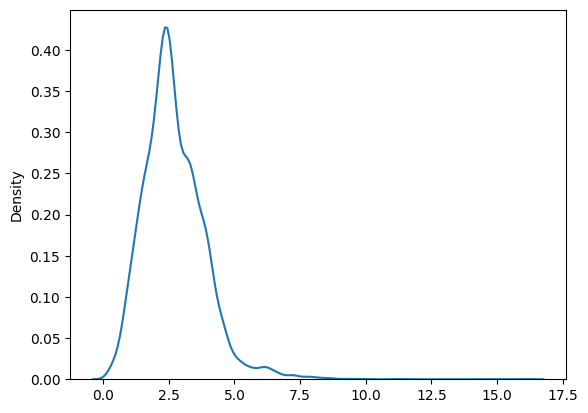

In [9]:
complete_filtered_data["start"]=complete_filtered_data["start"].astype(float)
complete_filtered_data["end"]=complete_filtered_data["end"].astype(float)
complete_filtered_data["length"]=complete_filtered_data["end"]-complete_filtered_data["start"]

sb.kdeplot(complete_filtered_data["length"].values)

### We'll make the constant length as 7.5s

Anything less than this we'll pad with zeros
Anything more than this we'll trim

In [10]:
def transformed_audio(audio_path: str,start: int,end: int) -> None:
    wv, sr = librosa.load(audio_path)
    '''
    
    sampling rate = no. of samples/time
    
    '''
    starting_point=int(max(sr*start,0))
    ending_point=int(min(sr*end,len(wv)))

    return wv[starting_point:ending_point],sr
    
complete_filtered_data.reset_index(inplace=True,drop=True)

In [11]:
path="./../Sound_Classification/archive/processed_data/"
c=0
files_saved=[]
files=[]
sr_coll=[]
samples_coll=[]

for index,row in complete_filtered_data.iterrows():
    maxLen=7.5
    start=row['start']
    end=row['end']
    audio_file_loc=row['audio_path']

    filename=audio_file_loc.split("/")[-1].split(".")[0]
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if complete_filtered_data.iloc[index-1]['audio_path'].split("/")[-1].split(".")[0]==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path="./../Sound_Classification/archive/processed_data/" + filename
    c+=1
    
    pureSample, sr=transformed_audio(audio_file_loc,start,end)

    
    reqLen=7.5*sr
    data = librosa.util.pad_center(data=pureSample,size=reqLen)

    
    sf.write(file=save_path,data=data,samplerate=sr)
    files.append(filename)
    files_saved.append(save_path)
    sr_coll.append(sr)
    samples_coll.append(len(pureSample))
    #break
print('Total Files Processed: ',c)

Total Files Processed:  6860


In [12]:
complete_filtered_data["samples"]=samples_coll
complete_filtered_data["sample rates"]=sr_coll
complete_filtered_data["filename"]=files
complete_filtered_data["file_save_path"]=files_saved

In [13]:
complete_filtered_data

,audio_path,start,end,crackles,weezels,target,length,samples,sample rates,filename,file_save_path
0,../Sound_Classification/archive/respiratory_so...,0.036,0.579,0.0,0.0,URTI,0.543,11973,22050,101_1b1_Al_sc_Meditron_919.wav,./../Sound_Classification/archive/processed_da...
1,../Sound_Classification/archive/respiratory_so...,0.579,2.450,0.0,0.0,URTI,1.871,41256,22050,101_1b1_Al_sc_Meditron_920.wav,./../Sound_Classification/archive/processed_da...
2,../Sound_Classification/archive/respiratory_so...,2.450,3.893,0.0,0.0,URTI,1.443,31818,22050,101_1b1_Al_sc_Meditron_921.wav,./../Sound_Classification/archive/processed_da...
3,../Sound_Classification/archive/respiratory_so...,3.893,5.793,0.0,0.0,URTI,1.900,41895,22050,101_1b1_Al_sc_Meditron_922.wav,./../Sound_Classification/archive/processed_da...
4,../Sound_Classification/archive/respiratory_so...,5.793,7.521,0.0,0.0,URTI,1.728,38103,22050,101_1b1_Al_sc_Meditron_923.wav,./../Sound_Classification/archive/processed_da...
...,...,...,...,...,...,...,...,...,...,...,...
6855,../Sound_Classification/archive/respiratory_so...,11.721,13.693,1.0,0.0,Pneumonia,1.972,43482,22050,226_1b1_Pl_sc_LittC2SE_6.wav,./../Sound_Classification/archive/processed_da...
6856,../Sound_Classification/archive/respiratory_so...,13.693,15.536,0.0,0.0,Pneumonia,1.843,40638,22050,226_1b1_Pl_sc_LittC2SE_7.wav,./../Sound_Classification/archive/processed_da...
6857,../Sound_Classification/archive/respiratory_so...,15.536,17.493,0.0,0.0,Pneumonia,1.957,43152,22050,226_1b1_Pl_sc_LittC2SE_8.wav,./../Sound_Classification/archive/processed_da...
6858,../Sound_Classification/archive/respiratory_so...,17.493,19.436,1.0,0.0,Pneumonia,1.943,42843,22050,226_1b1_Pl_sc_LittC2SE_9.wav,./../Sound_Classification/archive/processed_da...


In [14]:
complete_filtered_data.to_csv("../Sound_Classification/archive/processed_data.csv",index=None)